In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from fibheap import FibonacciHeap as FibHeap
from peel_by_motif import *
import random
import pandas as pd
from datetime import datetime
from compare_algs.greedy_algorithms import *
import graph_tool.all as gt

In [3]:
plt.rcParams.update({'font.size': 14})

# Read dataset

In [4]:
df = pd.read_csv('data/soc-sign-bitcoinalpha.csv', names=['source','sink','rate','time'])
G = nx.from_pandas_edgelist(df, 'source', 'sink',['rate'], create_using=nx.DiGraph())
index = 0
gt_node_map = {}
for n in G.nodes:
    gt_node_map[n] = index
    index += 1
g = gt.Graph()
for row in df[['source','sink','rate']].values:
    g.add_edge(gt_node_map[row[0]], gt_node_map[row[1]])

In [5]:
len(G.nodes), len(G.edges)

(3783, 24186)

# Edges with negative rating

In [6]:
bad_edges = []
for u,v in G.edges:
    if G[u][v]['rate']<0:
        bad_edges.append((u,v))
len(bad_edges)

1536

In [7]:
bad_ug = gt.Graph()
edge_induced = nx.Graph(bad_edges)
for row in df[['source','sink','rate']].values:
    if row[0] in edge_induced.nodes and row[1] in edge_induced.nodes:
        bad_ug.add_edge(gt_node_map[row[0]], gt_node_map[row[1]])

# count the number of motifs

In [8]:
start=datetime.now()
motif3 = gt.motifs(g, 3, return_maps=True)
print(datetime.now()-start)

0:00:09.763814


In [15]:
start=datetime.now()
motif4 = gt.motifs(g, 4)
print(datetime.now()-start)

0:07:50.578181


# Display motif occurances with size 3

0 43677


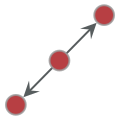

1 17083


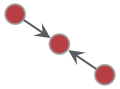

2 27095


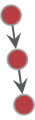

3 974


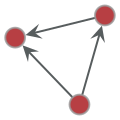

4 190593


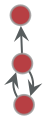

5 93989


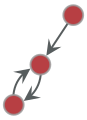

6 64


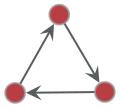

7 1780


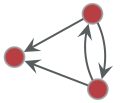

8 1142


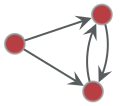

9 413062


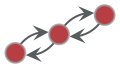

10 1163


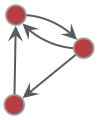

11 7136


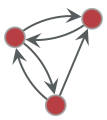

12 9894


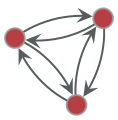

In [10]:
i = 0
for motif_shape in motif3[0]:
    print(i, motif3[1][i])
    i += 1
    gt.graph_draw(motif_shape,output_size=(60,60))
    plt.show()

In [34]:
bad_motif3 = gt.motifs(bad_ug, 3)

In [47]:
bad_motif4 = gt.motifs(bad_ug, 4)

# Compare motif histogram between whole graph and bad edge induced graph

[]

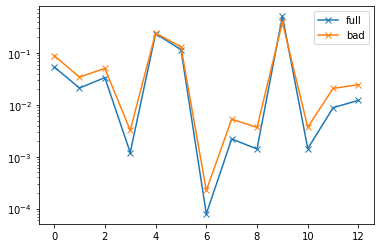

In [37]:
plt.plot([i/sum(motif3[1]) for i in motif3[1]],marker='x',label='full')
plt.plot([i/sum(bad_motif3[1]) for i in bad_motif3[1]],marker='x',label='bad')
plt.yscale('log')
plt.legend()
plt.plot()

[]

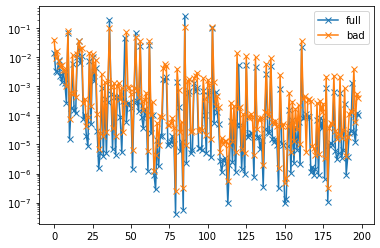

In [48]:
plt.plot([i/sum(motif4[1]) for i in motif4[1]],marker='x',label='full')
plt.plot([i/sum(bad_motif4[1]) for i in bad_motif4[1]],marker='x',label='bad')
plt.yscale('log')
plt.legend()
plt.plot()

# Compare motif histogram between original graph and configuration model

In [9]:
import random
indeg = [i[1] for i in G.in_degree]
outdeg = [i[1] for i in G.out_degree]
lamd = sum([i*j for i in indeg for j in outdeg])/len(G.edges)

rand_G = gt.Graph()
rand_G.add_vertex((len(indeg)))
for i in range(len(indeg)):
    for j in range(len(outdeg)):
        if i!=j and random.uniform(0, 1)<indeg[i]*outdeg[j]/lamd:
            rand_G.add_edge(i,j)

In [10]:
rand_motif3 = gt.motifs(rand_G, 3)

[]

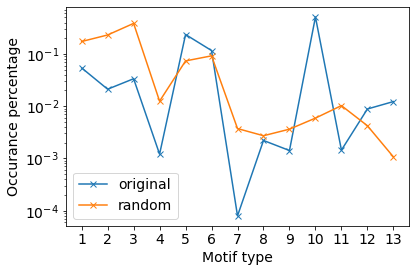

In [11]:
plt.plot([str(i) for i in range(1,14)], [i/sum(motif3[1]) for i in motif3[1]],marker='x',label='original')
plt.plot([str(i) for i in range(1,14)], [i/sum(rand_motif3[1]) for i in rand_motif3[1]],marker='x',label='random')
plt.yscale('log')
plt.ylabel('Occurance percentage')
plt.xlabel('Motif type')
plt.legend()
plt.tight_layout()
plt.savefig('figs/bitcoin_alpha/random_compare.png')
plt.plot()

# Peel three times with motif contrast strategy

In [15]:
num_labeled_G = nx.relabel_nodes(G, gt_node_map)

In [26]:
def three_time_dsd(motif3, num_labeled_G, pos_motif_inds, neg_motif_inds, neg_val=-1):
    h_list = []
    removed_nodes = []
    pairs = []
    for pos_motif_ind in pos_motif_inds:
        pairs.append(([list(i) for i in motif3[2][pos_motif_ind]],1))
    for neg_motif_ind in neg_motif_inds:
        pairs.append(([list(i) for i in motif3[2][neg_motif_ind]],neg_val))
#     pairs= [([list(i) for i in motif3[2][pos_motif_ind]],1),([list(i) for i in motif3[2][neg_motif_ind]],neg_val)]
    for i in range(3):
    #     print('!!', len(pairs[0][0]))
        node_d, fibheap = init_heap_and_dict(pairs)
        results = peel_by_motif(node_d, fibheap, pairs, 1, False)
        print(results[3])
        H = num_labeled_G.subgraph(results[1])
        removed_nodes += list(H.nodes)
        h_list.append(H)

        rates = nx.get_edge_attributes(H, "rate")
        value_list = list(rates.values())
        vs = plt.hist(value_list)
        plt.xlabel('rate of edges')
        plt.ylabel('number of edges')
        plt.tight_layout()
        plt.savefig('figs/bitcoin_alpha/contrast_hist_'+str(i)+'.png')
        plt.show()

        colors = ['g' if H[u][v]['rate']>0 else 'r' for u,v in H.edges]
        nx.draw_shell(H, node_size=50, edge_color=colors, arrowsize=20)
        plt.tight_layout()
        plt.savefig('figs/bitcoin_alpha/contrast_shape_'+str(i)+'.png')
        plt.show()

        new_pairs = []
        for pair in pairs:
            temp_motif_list = []
    #         print(len(pair[0]))
            for motif in pair[0]:
    #             print(motif)
                flag = 0
                for node in motif:

                    if node in removed_nodes:
                        flag = 1
                        break
                if flag == 0:
                    temp_motif_list.append(motif)
            new_pairs.append((temp_motif_list, pair[1]))
    #         print(len(temp_motif_list))
        pairs = new_pairs
    return h_list

[31, 0]


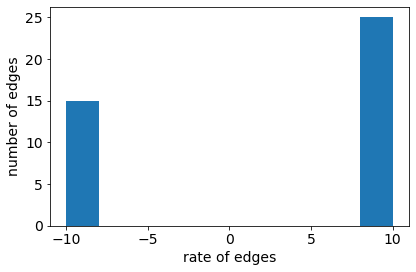

<ipython-input-26-4dadca55e236>:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


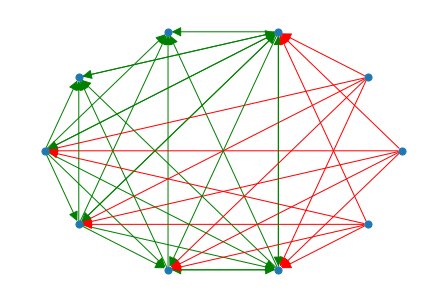

[7, 0]


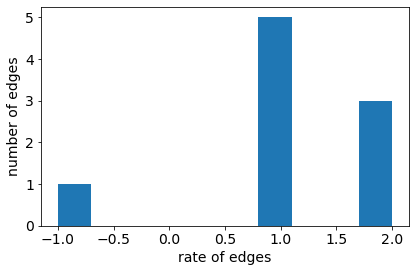

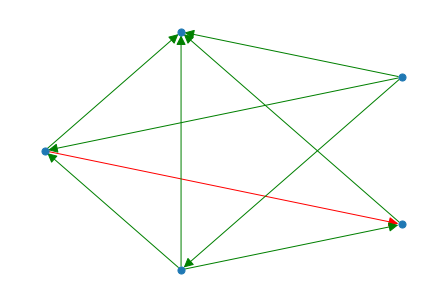

[6, 0]


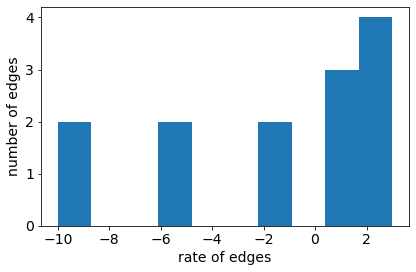

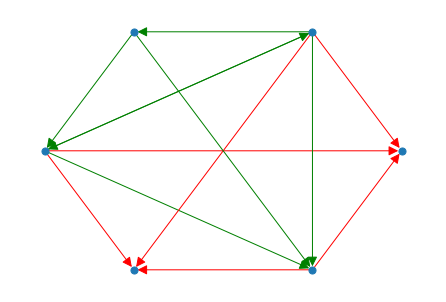

In [29]:
g_3_9 = three_time_dsd(motif3, num_labeled_G, [3], [9], neg_val=-1)

[14, 0]


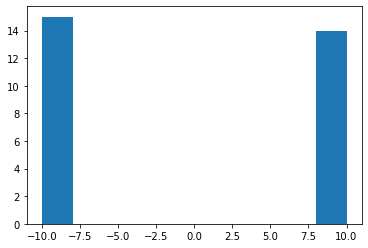

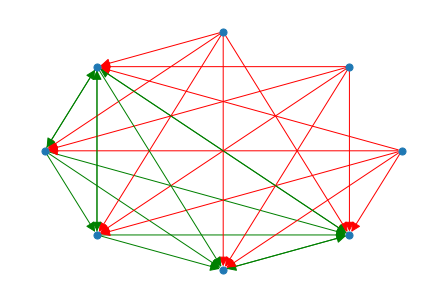

[2, 0]


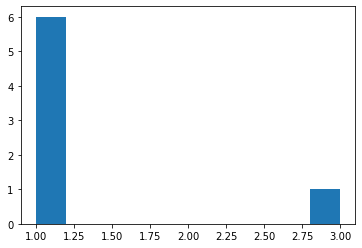

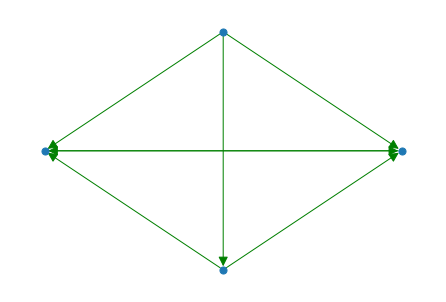

[4, 0]


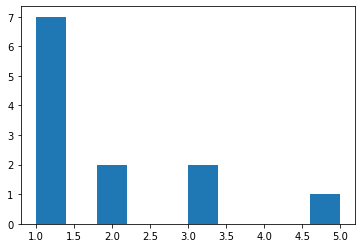

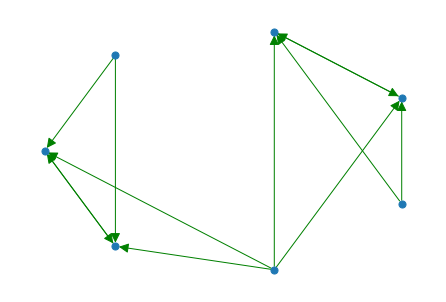

In [18]:
g_8_9 = three_time_dsd(motif3, num_labeled_G, [8], [9], neg_val=-1)

# quasi clique greedy peeling as comparison
check https://tsourakakis.com/2015/07/08/k-clique-densest-subgraph-problem/ for algorithm detail

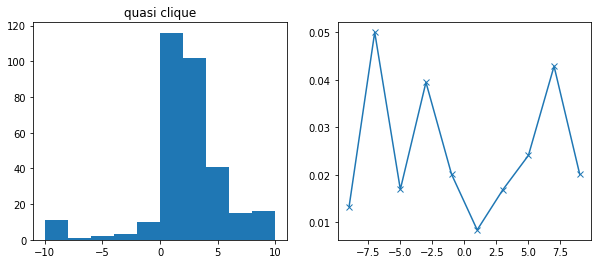

In [18]:

dense_sub = greedy_quasi_cliques(G, 0.5)
rates = nx.get_edge_attributes(dense_sub, "rate")
value_list = list(rates.values())
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
vs = ax1.hist(value_list)
ax1.set_title('quasi clique')
ax2.plot(vs[1][:-1]+1,vs[0]/total_vs[0], marker='x')
plt.show()

# Some less interesting / unsuccessful motif pairs

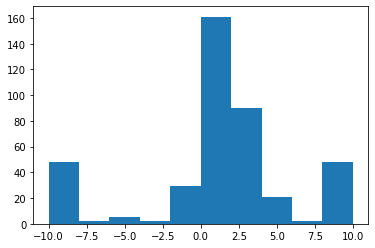

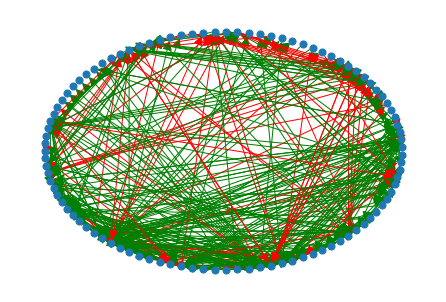

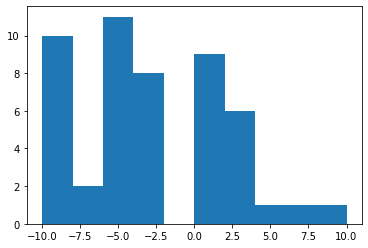

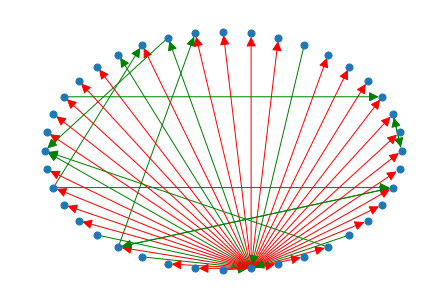

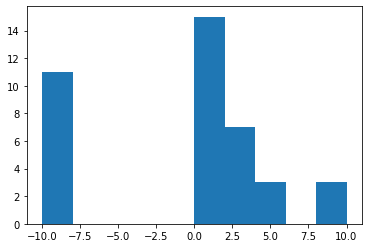

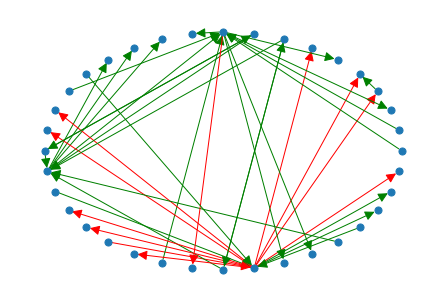

In [67]:
g_2_9 = three_time_dsd(motif3, num_labeled_G, [2], [9], neg_val=-1)

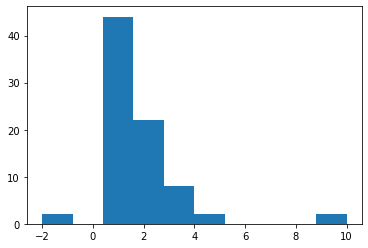

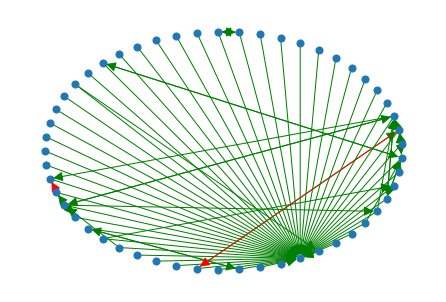

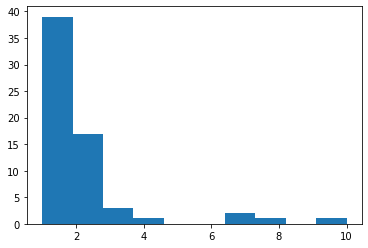

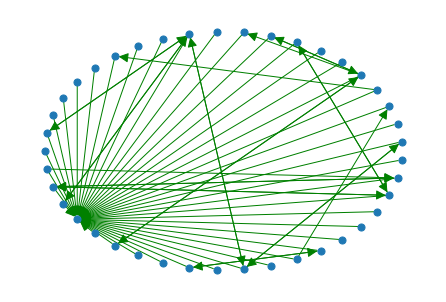

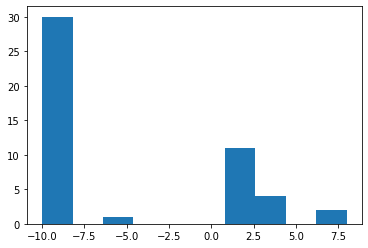

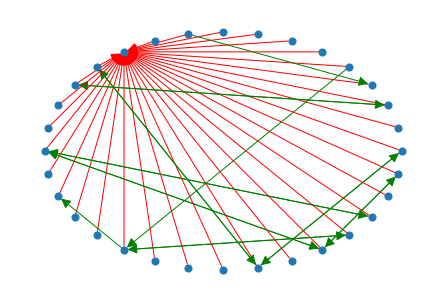

In [66]:
g_1_9 = three_time_dsd(motif3, num_labeled_G, [1], [9], neg_val=-1)

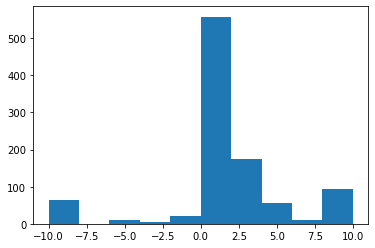

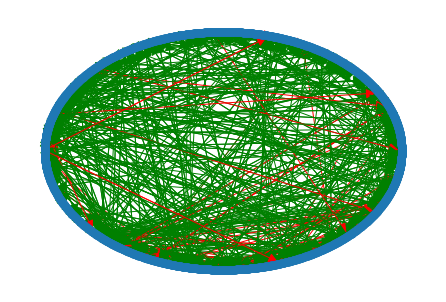

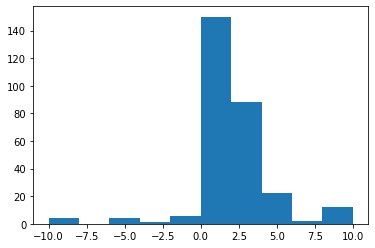

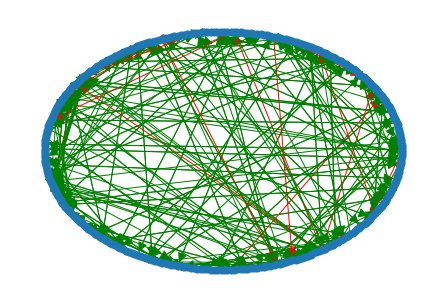

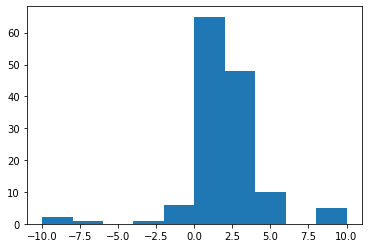

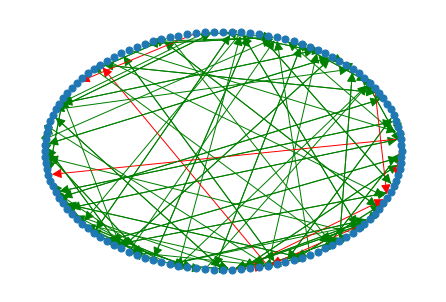

In [56]:
three_time_dsd(motif3, num_labeled_G, [6], [9], neg_val=-1)